In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Encoder

In [2]:
class sampling(layers.Layer):
  
  def call(self, inputs):
    z_mean = inputs[0]
    z_std = inputs[1]
    batch_size = tf.shape(z_mean)[0]
    latent_shape = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal((batch_size,latent_shape))
    return z_mean + tf.exp(0.5 * z_std) * epsilon

In [3]:
x = keras.Input(shape=(28,28,1),dtype=tf.float32,name="input_layer")
flattened = keras.layers.Flatten(name="flattend_input_layer")(x)
encoder_layer = keras.layers.Dense(512,activation=tf.nn.tanh,name="encoder_layer")(flattened)
mean = keras.layers.Dense(2,name="mean_layer")(encoder_layer)
std = keras.layers.Dense(2,name="std_layer")(encoder_layer)
z = sampling(name="sampling_layer")([mean,std])
encoder = keras.Model(x, [mean,std,z,flattened])
encoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
flattend_input_layer (Flatten)  (None, 784)          0           input_layer[0][0]                
__________________________________________________________________________________________________
encoder_layer (Dense)           (None, 512)          401920      flattend_input_layer[0][0]       
__________________________________________________________________________________________________
mean_layer (Dense)              (None, 2)            1026        encoder_layer[0][0]              
______________________________________________________________________________________________

# Decoder

In [4]:
decoder_input = keras.Input(shape=(2,))
decoder_layer = keras.layers.Dense(512,activation=tf.nn.tanh,name="decoder_layer")(decoder_input)
reconstructed = keras.layers.Dense(784,activation=tf.nn.sigmoid,name="reconstructed")(decoder_layer)
reconstructed_image = keras.layers.Reshape((28,28),name="reconstructed_image")(reconstructed)
decoder = keras.Model(decoder_input,[reconstructed,reconstructed_image])
decoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
decoder_layer (Dense)        (None, 512)               1536      
_________________________________________________________________
reconstructed (Dense)        (None, 784)               402192    
_________________________________________________________________
reconstructed_image (Reshape (None, 28, 28)            0         
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________


# Model

In [5]:
class VAE(keras.Model):

  def __init__(self,encoder,decoder,**kwargs):
    super(VAE, self).__init__(**kwargs)

    self.encoder = encoder
    self.decoder = decoder
    self.reconstraction_loss_tracker = keras.metrics.Mean(name="Reconstraction_loss")
    self.kl_loss_tracker = keras.metrics.Mean(name="KL_loss")
    self.total_loss_tracker = keras.metrics.Mean(name="Total_loss")


  @property
  def metrics(self):
    return [
        self.reconstraction_loss_tracker,
        self.kl_loss_tracker,
        self.total_loss_tracker 
    ]

  
  def train_step(self,data):
    with tf.GradientTape() as tape:
      z_mean, z_log_var, z , flattened_img = self.encoder(data)
      reconstruction , _ = self.decoder(z)
      re_loss = flattened_img* tf.math.log(reconstruction+1e-10) + (1-flattened_img)* tf.math.log(1-reconstruction+1e-10)
      reconstraction_loss = tf.reduce_mean(
            -tf.reduce_sum(
                re_loss ,axis=1
            )     
      )
      
      kl_loss = tf.reduce_mean(  -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)) )

      total_loss = reconstraction_loss + kl_loss
      
    grads = tape.gradient(total_loss , self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
    self.reconstraction_loss_tracker.update_state(reconstraction_loss)
    self.kl_loss_tracker.update_state(kl_loss)
    self.total_loss_tracker.update_state(total_loss)
    return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstraction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


load dataset


In [6]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x = np.concatenate([x_train,x_test],axis=0)
y = np.concatenate([y_train,y_test],axis=0)

In [7]:
x.shape

(70000, 28, 28)

In [8]:
mnist_digits = np.expand_dims(x, -1).astype("float32") / 255

In [9]:
mnist_digits.shape

(70000, 28, 28, 1)

In [10]:
model = VAE(encoder,decoder)
model.compile(optimizer='adam')
model.fit(mnist_digits, epochs=5, batch_size=128)

Epoch 1/5
547/547 [==============================] - 4s 5ms/step - total_loss: 228.0977 - reconstruction_loss: 218.1434 - kl_loss: 9.9543
Epoch 2/5
547/547 [==============================] - 3s 5ms/step - total_loss: 178.4525 - reconstruction_loss: 175.3885 - kl_loss: 3.0640
Epoch 3/5
547/547 [==============================] - 3s 5ms/step - total_loss: 173.7051 - reconstruction_loss: 170.6302 - kl_loss: 3.0749
Epoch 4/5
547/547 [==============================] - 3s 5ms/step - total_loss: 168.8657 - reconstruction_loss: 165.6783 - kl_loss: 3.1874
Epoch 5/5
547/547 [==============================] - 3s 5ms/step - total_loss: 165.0776 - reconstruction_loss: 161.8165 - kl_loss: 3.2610


# Visualization


In [11]:
def plot_reconstructed(on_x_axis=5,on_y_axis= 5,fig_size=(12,12)):
  import matplotlib.pyplot as plt

  _,_,z,_ =   model.encoder(mnist_digits[:on_x_axis*on_y_axis])
  _,reconstructed_images=model.decoder(z)
  reconstructed_images = reconstructed_images.numpy()
  figure = np.zeros((28 * on_x_axis, 28*on_y_axis))
  for i in range(on_x_axis):
    for j in range(on_y_axis):
      figure[i*28:(i+1)*28 , j*28:(j+1)*28 ] = reconstructed_images[i*on_y_axis+j]
  plt.figure(figsize=fig_size)
  plt.imshow(figure,cmap="Greys_r")


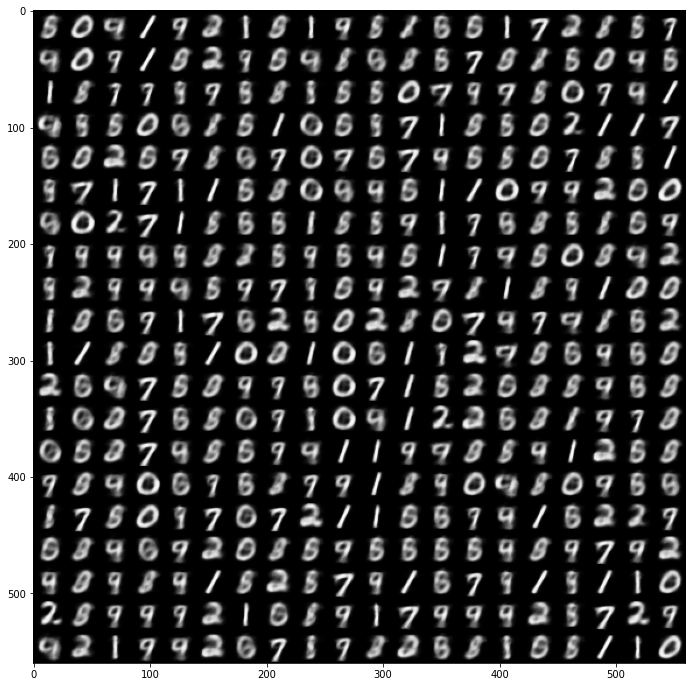

In [12]:
plot_reconstructed(20,20)

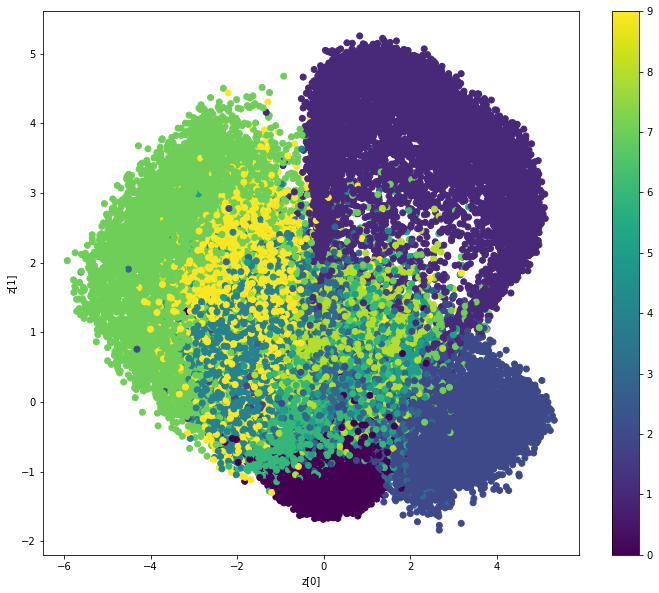

In [15]:
def plot_label_clusters():
    import matplotlib.pyplot as plt
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _,_ = model.encoder(mnist_digits)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

plot_label_clusters()